<a href="https://www.kaggle.com/code/yunusemreakca/podcastpredict-eda?scriptVersionId=236243571" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
import lightgbm as lgb
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import ExtraTreesRegressor

from warnings import filterwarnings
filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


# First Look

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e4/test.csv")

In [3]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [4]:
test.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           250000 non-null  int64  
 1   Podcast_Name                 250000 non-null  object 
 2   Episode_Title                250000 non-null  object 
 3   Episode_Length_minutes       221264 non-null  float64
 4   Genre                        250000 non-null  object 
 5   Host_Popularity_percentage   250000 non-null  float64
 6   Publication_Day              250000 non-null  object 
 7   Publication_Time             250000 non-null  object 
 8   Guest_Popularity_percentage  201168 non-null  float64
 9   Number_of_Ads                250000 non-null  float64
 10  Episode_Sentiment            250000 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 21.0+ MB


In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,750000.0,374999.500000,216506.495284,0.0,187499.75000,374999.50000,562499.25000,749999.00
Episode_Length_minutes,662907.0,64.504738,32.969603,0.0,35.73000,63.84000,94.07000,325.24
Host_Popularity_percentage,750000.0,59.859901,22.873098,1.3,39.41000,60.05000,79.53000,119.46
Guest_Popularity_percentage,603970.0,52.236449,28.451241,0.0,28.38000,53.58000,76.60000,119.91
Number_of_Ads,749999.0,1.348855,1.151130,0.0,0.00000,1.00000,2.00000,103.91
Listening_Time_minutes,750000.0,45.437406,27.138306,0.0,23.17835,43.37946,64.81158,119.97


In [8]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,250000.0,874999.500000,72168.927986,750000.00,812499.75,874999.50,937499.25,999999.00
Episode_Length_minutes,221264.0,419.298741,166854.502468,2.47,35.78,63.97,94.15,78486264.00
Host_Popularity_percentage,250000.0,59.716491,22.880028,2.49,39.25,59.90,79.39,117.76
Guest_Popularity_percentage,201168.0,52.192796,28.445034,0.00,28.32,53.36,76.56,116.82
Number_of_Ads,250000.0,1.355852,4.274399,0.00,0.00,1.00,2.00,2063.00


## Numerical Features

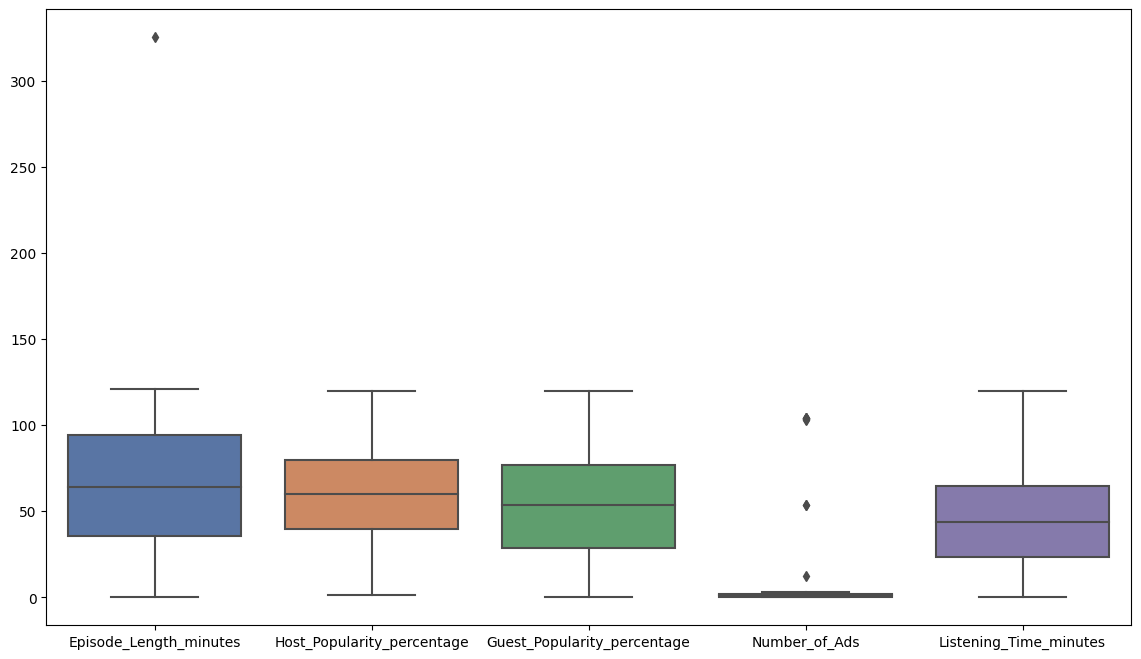

In [9]:
plt.figure(figsize =(14,8))
sns.boxplot(train.drop(["id"],axis = 1) ,palette ="deep")
plt.show()

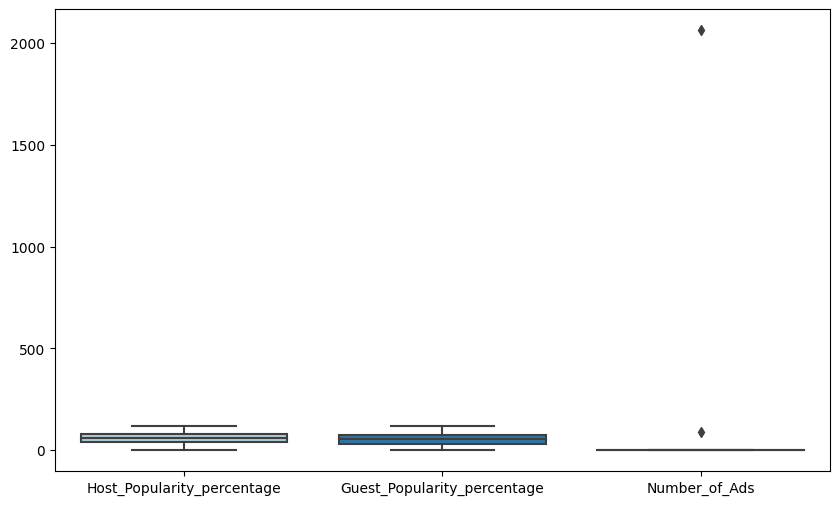

In [10]:
plt.figure(figsize =(10,6))
sns.boxplot(test.drop(["id","Episode_Length_minutes"],axis = 1) ,palette ="Paired")
plt.show()

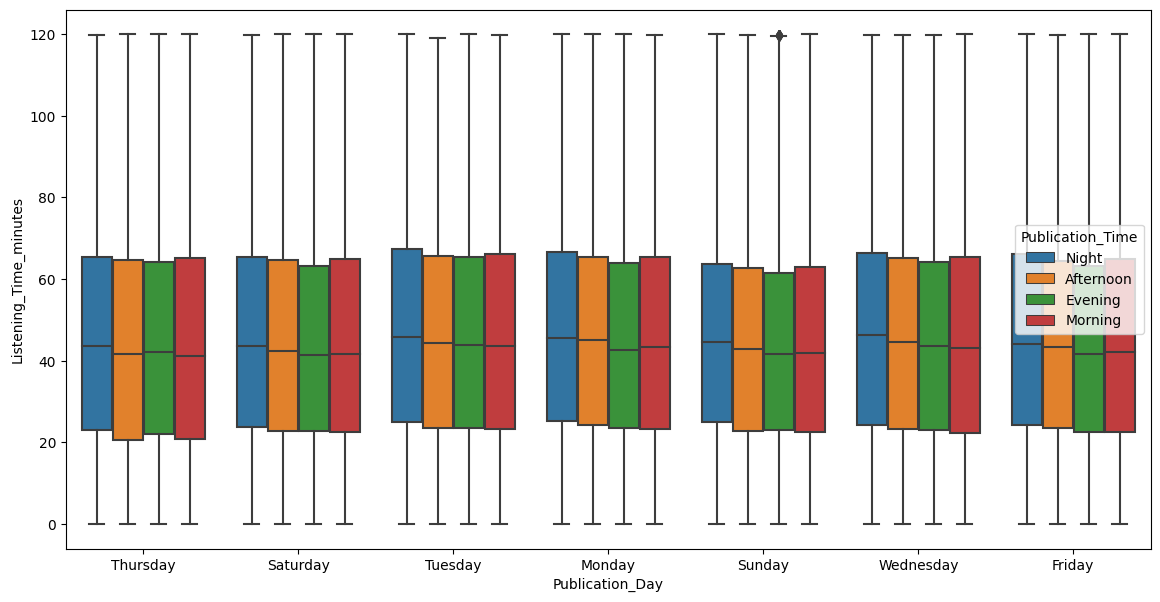

In [11]:
plt.figure(figsize = (14,7))
sns.boxplot(x= "Publication_Day" ,y= "Listening_Time_minutes", hue = "Publication_Time", data = train)
plt.show()

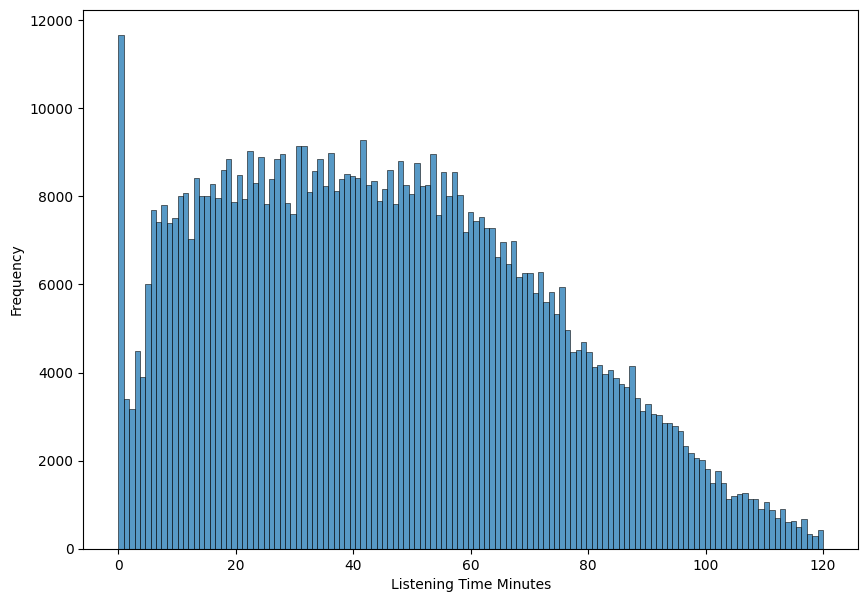

In [12]:
plt.figure(figsize = (10,7))
sns.histplot(train["Listening_Time_minutes"])
plt.xlabel("Listening Time Minutes")
plt.ylabel("Frequency")
plt.show()

### 1. Rest Period & Broadcast Day / Time
I drew a box plot to understand the effect of the broadcast day (`Publication_Day`) and time (`Publication_Time`) on the rest time.

- The median of each day is quite close to each other. 
- There is no significant difference depending on the time of the day, but there are small fluctuations in the episodes aired in the morning and at night.
- Maybe it would be useful to create a new combo column `day + hour`.

### 2. Outlier Checks
I made a box plot for the numeric columns in both train and test data.

- `Episode_Length_minutes` is out of whack in the test set, there is a ridiculous value like 78 million. Probably an incorrect record.
- `Number_of_Ads` contains a value over 2000 in the test, again a very extreme value.
- Train is more stable, but there are a few outliers there too.

So:
- At this stage I may need to either remove these outliers or try something like log/robust scaler to reduce their impact.
- Maybe I need to clean columns like `Episode_Length_minutes` before the model.

### 3. Popularity and Number of Ads
I drew separate graphs for `Host_Popularity_percentage`, `Guest_Popularity_percentage` and `Number_of_Ads`.

- In general, it seems that the higher the popularity, the higher the rest time. 
- Very large values in the number of ads are rare but may have an effect.
- Maybe it would make more sense to divide `Number_of_Ads` into categorical groups (such as less-medium-more).


## Categorical Features

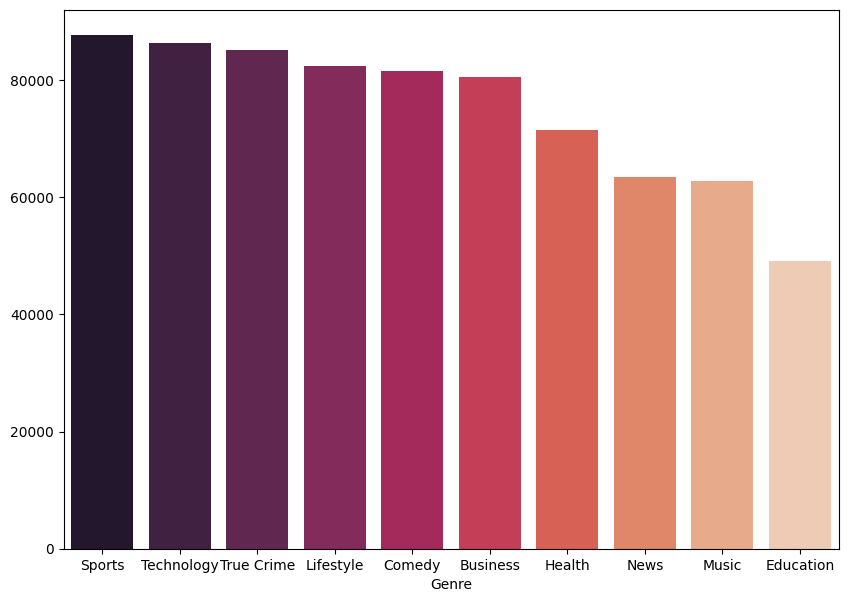

In [13]:
plt.figure(figsize = (10,7))
top_categories = train["Genre"].value_counts().nlargest(10)
sns.barplot(x=top_categories.index, y=top_categories.values,palette = "rocket")
plt.show()

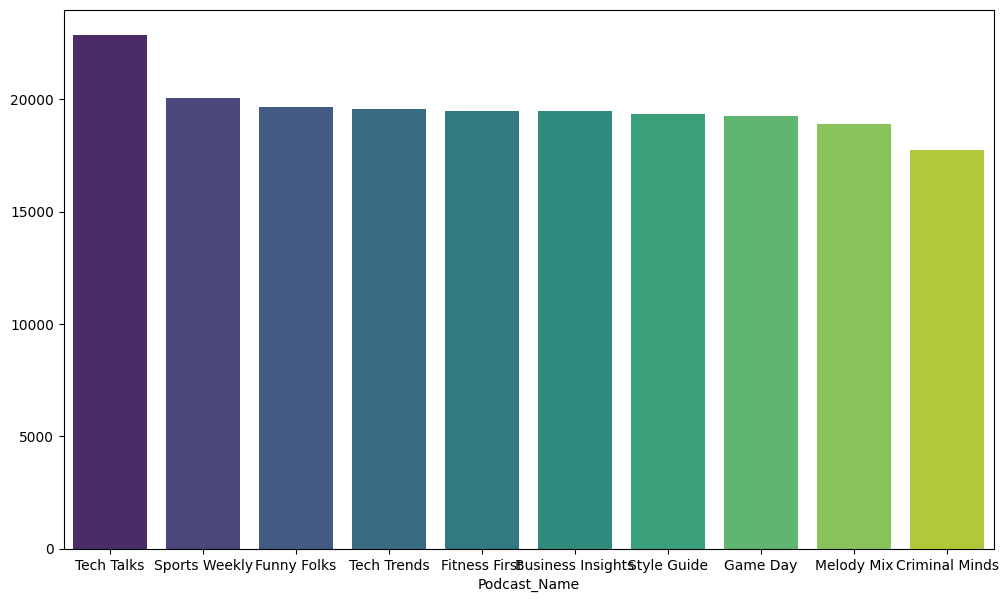

In [14]:
plt.figure(figsize = (12,7))
top_categories = train["Podcast_Name"].value_counts().nlargest(10)
sns.barplot(x=top_categories.index, y=top_categories.values,palette = "viridis")
plt.show()

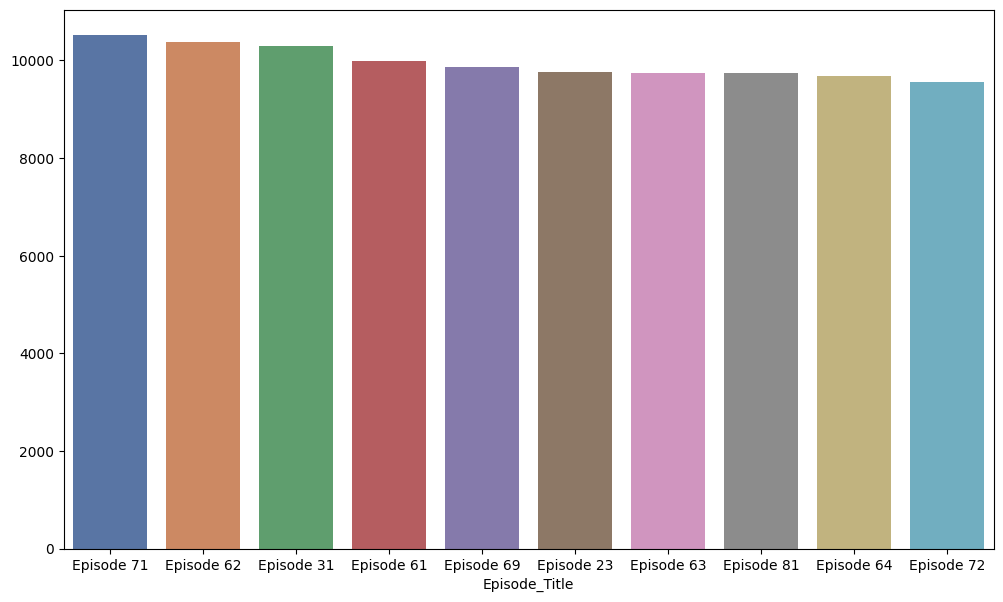

In [15]:
plt.figure(figsize = (12,7))
top_categories = train["Episode_Title"].value_counts().nlargest(10)
sns.barplot(x=top_categories.index, y=top_categories.values,palette = "deep")
plt.show()

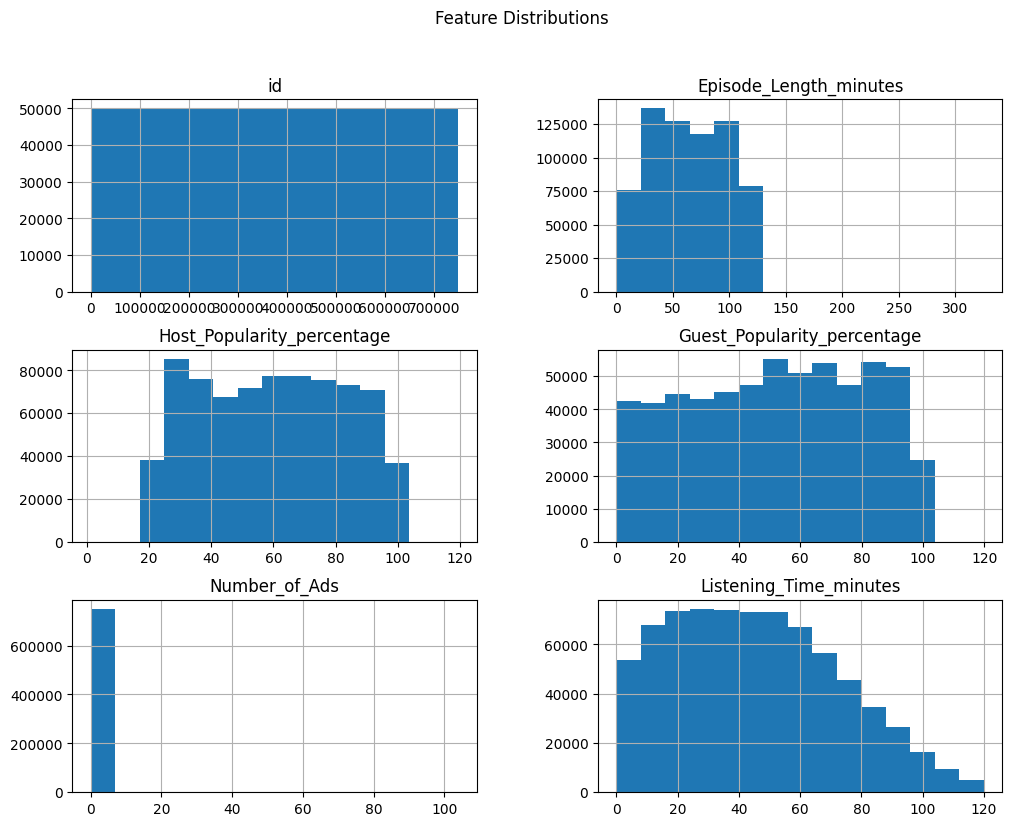

In [16]:
train.hist(figsize=(12, 9), bins=15)
plt.suptitle("Feature Distributions")
plt.show()

# Correlation Analysis

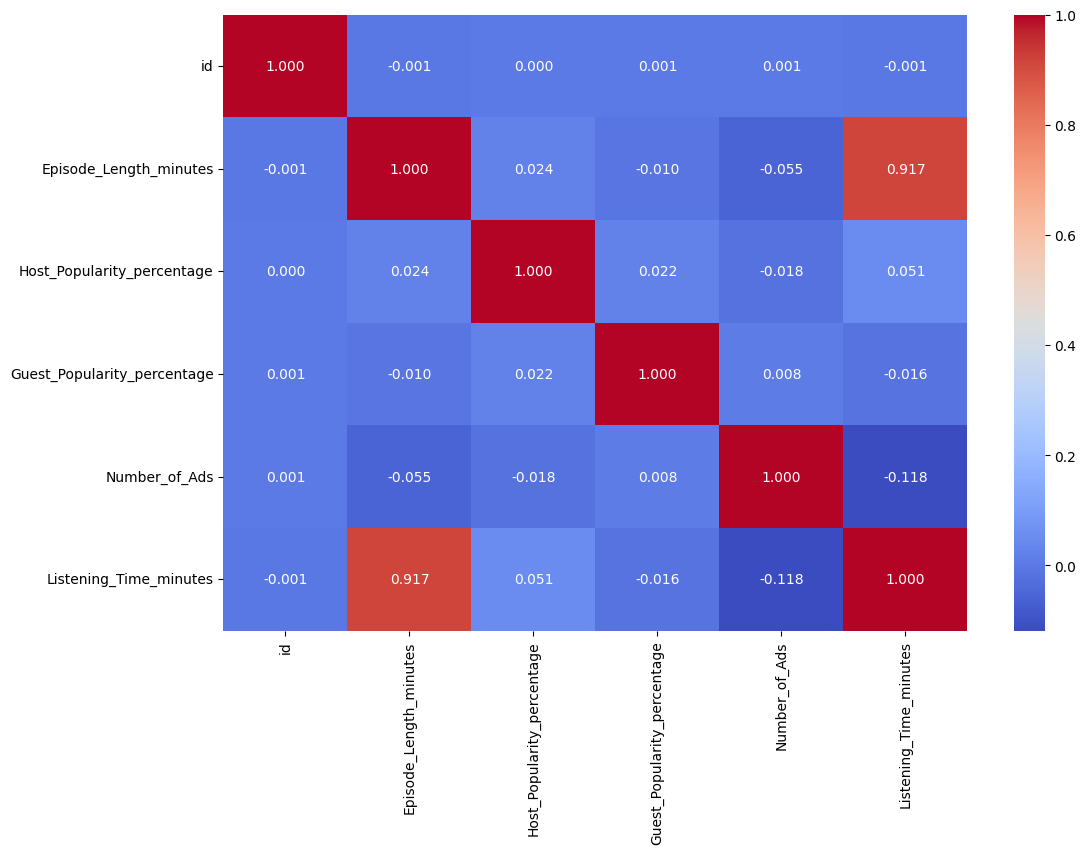

In [17]:
corr = train.select_dtypes(["int64","float64"]).corr()
plt.figure(figsize =(12,8))
sns.heatmap(corr,annot = True,cmap ="coolwarm",fmt = ".3f")
plt.show()

* There is a very high positive correlation between Episode_Length_minutes and Listening_Time_minutes (0.92). This makes sense because the longer an episode is, the longer the listening time is usually.

* There is a negative but weak correlation between Number_of_Ads and the target variable (-0.12). Maybe too many ads might be driving listeners away, but the effect seems low.

* There is no significant correlation between the other numeric variables and Listening_Time. Therefore, these variables can be improved with feature engineering touches.

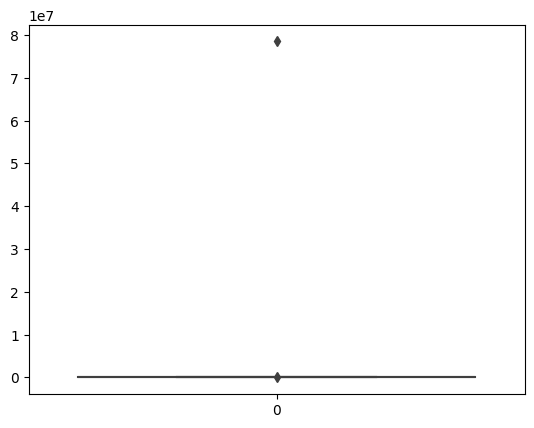

In [18]:
sns.boxplot(test["Episode_Length_minutes"])
plt.show()

In [19]:
test[test["Episode_Length_minutes"] > 1e6]

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
56597,806597,Market Masters,Episode 23,78486264.0,Business,55.45,Monday,Evening,48.5,0.0,Positive


# Outlier Dedection 

## Train Episode Lenght Minutes

In [20]:
Q3 = train["Episode_Length_minutes"].quantile(0.75)
Q1 = train["Episode_Length_minutes"].quantile(0.25)
IQR = Q3 - Q1
Upper_limit = Q3 + 1.5 * IQR

In [21]:
outlier = train["Episode_Length_minutes"] > Upper_limit
train.loc[outlier, "Episode_Length_minutes"] = train["Episode_Length_minutes"].mean()

## Train Number_of_Ads

In [22]:
Q3 = train["Number_of_Ads"].quantile(0.75)
Q1 = train["Number_of_Ads"].quantile(0.25)
IQR = Q3 - Q1
Upper_limit = Q3 + 1.5 * IQR

In [23]:
outlier = train["Number_of_Ads"] > Upper_limit
train.loc[outlier, "Number_of_Ads"] = train["Number_of_Ads"].mean()

## Test Number_of_Ads

In [24]:
Q3 = test["Number_of_Ads"].quantile(0.75)
Q1 = test["Number_of_Ads"].quantile(0.25)
IQR = Q3 - Q1
Upper_limit = Q3 + 1.5 * IQR

In [25]:
outlier = test["Number_of_Ads"] > Upper_limit
test.loc[outlier, "Number_of_Ads"] = test["Number_of_Ads"].mean()

## Test Episode Length Minutes

In [26]:
Q3 = test["Episode_Length_minutes"].quantile(0.75)
Q1 = test["Episode_Length_minutes"].quantile(0.25)
IQR = Q3 - Q1
Upper_limit = Q3 + 3 * IQR

In [27]:
outlier = test["Episode_Length_minutes"] > Upper_limit
test.loc[outlier, "Episode_Length_minutes"] = test["Episode_Length_minutes"].mean()

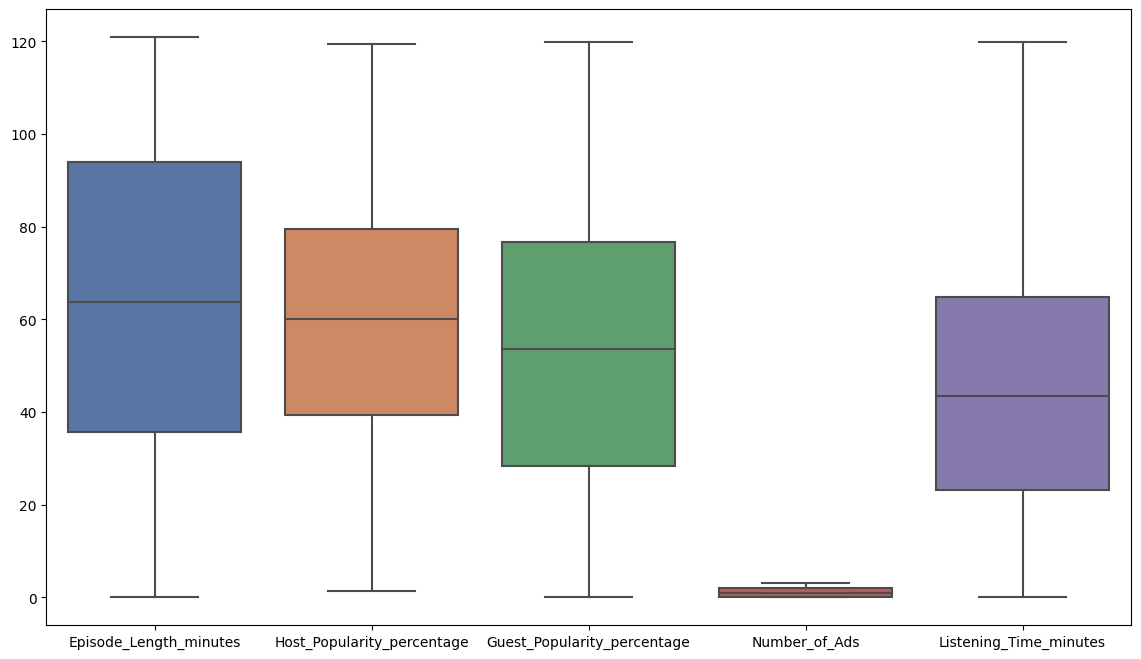

In [28]:
plt.figure(figsize =(14,8))
sns.boxplot(train.drop(["id"],axis = 1) ,palette ="deep")
plt.show()

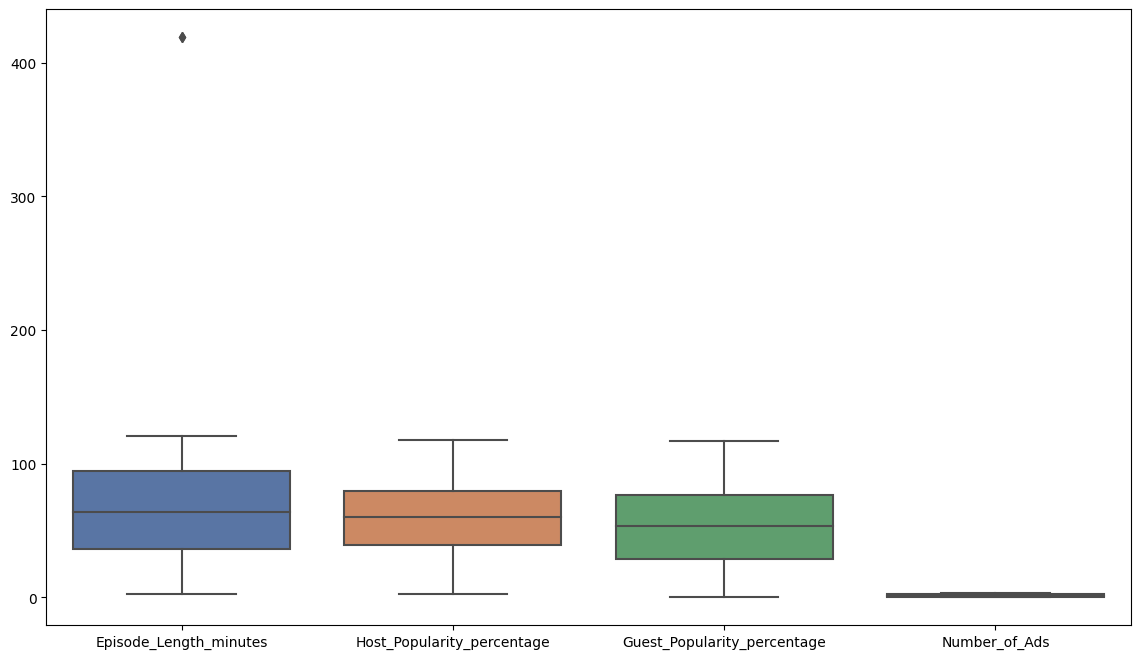

In [29]:
plt.figure(figsize =(14,8))
sns.boxplot(test.drop(["id"],axis = 1) ,palette ="deep")
plt.show()

# Feature Engineering

## Missing Data

In [30]:
print(train.isnull().sum())
print("----------------------------------------------------------")
print(test.isnull().sum())

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64
----------------------------------------------------------
id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64


In [31]:
print(train.isnull().sum()/ len(train) * 100)
print("----------------------------------------------------------")
print(test.isnull().sum()/ len(train) * 100)

id                              0.000000
Podcast_Name                    0.000000
Episode_Title                   0.000000
Episode_Length_minutes         11.612400
Genre                           0.000000
Host_Popularity_percentage      0.000000
Publication_Day                 0.000000
Publication_Time                0.000000
Guest_Popularity_percentage    19.470667
Number_of_Ads                   0.000133
Episode_Sentiment               0.000000
Listening_Time_minutes          0.000000
dtype: float64
----------------------------------------------------------
id                             0.000000
Podcast_Name                   0.000000
Episode_Title                  0.000000
Episode_Length_minutes         3.831467
Genre                          0.000000
Host_Popularity_percentage     0.000000
Publication_Day                0.000000
Publication_Time               0.000000
Guest_Popularity_percentage    6.510933
Number_of_Ads                  0.000000
Episode_Sentiment              0.0

In [32]:
train['Number_of_Ads'].fillna(train['Number_of_Ads'].median(), inplace=True)

train['Episode_Length_minutes'].fillna(train['Episode_Length_minutes'].median(), inplace=True)
test['Episode_Length_minutes'].fillna(test['Episode_Length_minutes'].median(), inplace=True)

train['Guest_Popularity_percentage'].fillna(train['Guest_Popularity_percentage'].median(), inplace=True)
test['Guest_Popularity_percentage'].fillna(test['Guest_Popularity_percentage'].median(), inplace=True)

## Feature Creation

In [33]:
train["Text_Lenght_Name"] = train["Podcast_Name"].apply(len)
test["Text_Lenght_Name"] = test["Podcast_Name"].apply(len)


def create_meaningful_arithmetic_features(df):
    epsilon = 1e-6
    
    df['Host_Popularity_per_Minute'] = df['Host_Popularity_percentage'] / (df['Episode_Length_minutes'] + epsilon)
    df['Guest_Popularity_per_Minute'] = df['Guest_Popularity_percentage'] / (df['Episode_Length_minutes'] + epsilon)

    df['Ads_per_Minute'] = df['Number_of_Ads'] / (df['Episode_Length_minutes'] + epsilon)

    df['Host_Guest_Popularity_Ratio'] = (df['Host_Popularity_percentage'] + epsilon) / (df['Guest_Popularity_percentage'] + epsilon)
    df['Guest_Host_Popularity_Ratio'] = (df['Guest_Popularity_percentage'] + epsilon) / (df['Host_Popularity_percentage'] + epsilon)

    df['Total_Popularity'] = df['Host_Popularity_percentage'] + df['Guest_Popularity_percentage']

    df['Popularity_Difference'] = df['Host_Popularity_percentage'] - df['Guest_Popularity_percentage']

    df['Ads_per_Host_Popularity'] = df['Number_of_Ads'] / (df['Host_Popularity_percentage'] + epsilon)
    df['Ads_per_Guest_Popularity'] = df['Number_of_Ads'] / (df['Guest_Popularity_percentage'] + epsilon)

    return df

train = create_meaningful_arithmetic_features(train.copy())
test = create_meaningful_arithmetic_features(test.copy())

In [34]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,...,Text_Lenght_Name,Host_Popularity_per_Minute,Guest_Popularity_per_Minute,Ads_per_Minute,Host_Guest_Popularity_Ratio,Guest_Host_Popularity_Ratio,Total_Popularity,Popularity_Difference,Ads_per_Host_Popularity,Ads_per_Guest_Popularity
0,0,Mystery Matters,Episode 98,63.84,True Crime,74.81,Thursday,Night,53.58,0.0,...,15,1.171836,0.839286,0.000000,1.396230,0.716214,128.39,21.23,0.000000,0.000000
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,...,13,0.558848,0.633973,0.016694,0.881501,1.134429,142.90,-9.00,0.029873,0.026333
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,...,14,0.946820,0.121380,0.000000,7.800445,0.128198,78.94,61.00,0.000000,0.000000
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,...,14,0.851868,1.171654,0.029775,0.727065,1.375393,135.92,-21.48,0.034953,0.025413
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,...,11,0.724550,0.530993,0.027147,1.364519,0.732859,138.75,21.39,0.037467,0.051125


## Feature Scaling

In [35]:
X = train.drop(["id","Listening_Time_minutes","Podcast_Name","Episode_Title"],axis=1)
y = train["Listening_Time_minutes"]
X_test = test.drop(["id","Podcast_Name","Episode_Title"],axis=1)

numeric_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])

X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_cols)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numeric_cols)


## Feature Encoding

In [36]:
train['Is_Episode_Length_Missing'] = train['Episode_Length_minutes'].isnull().astype(int)
test['Is_Episode_Length_Missing'] = test['Episode_Length_minutes'].isnull().astype(int)

train['Is_Guest_Popularity_Missing'] = train['Guest_Popularity_percentage'].isnull().astype(int)
test['Is_Guest_Popularity_Missing'] = test['Guest_Popularity_percentage'].isnull().astype(int)

In [37]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
pref = ["Gen","Day","Time","Sent"]

X_train_encode = pd.get_dummies(data = X ,columns =  categorical_cols, prefix = pref,drop_first = True)
X_test_encode = pd.get_dummies(data = X_test,columns = categorical_cols,prefix = pref,drop_first=True)

bool_columns = X_train_encode.select_dtypes(include = "bool").columns
X_train_encode[bool_columns] = X_train_encode[bool_columns].astype(int)

bool_columns = X_test_encode.select_dtypes(include = "bool").columns
X_test_encode[bool_columns] = X_test_encode[bool_columns].astype(int)

In [38]:
X_categorical = X_train_encode.drop(numeric_cols, axis=1)
X_train_final = pd.concat([X_scaled_df, X_categorical.reset_index(drop=True)], axis=1)

X_categorical_test = X_test_encode.drop(numeric_cols, axis=1)
X_scaled_test_final = pd.concat([X_test_scaled_df, X_categorical_test.reset_index(drop=True)], axis=1)

## Machine Learning

## XGBoost 

 {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 10, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.7}

In [39]:
xgb_model = XGBRegressor(random_state = 42,colsample_bytree = 0.7,gamma =1,learning_rate = 0.05,max_depth= 10,n_estimators = 1000,subsample = 0.8,reg_lambda = 0.1,reg_alpha = 10)

In [40]:
scores = cross_val_score(xgb_model, X_train_final, y, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = np.abs(scores)
print(f"Mean AUC: {rmse_scores.mean():.4f}")

Mean AUC: 12.8505


In [41]:
xgb_model.fit(X_train_final , y)
y_test_pred = xgb_model.predict(X_scaled_test_final)

In [42]:
submission = pd.DataFrame({
    "id": test["id"],
    "Episode_Length_minutes": y_test_pred
})

submission.to_csv("submission_xgboost_podcast.csv", index=False)

## Lasso

Best parameters: {'alpha': 0.001, 'max_iter': 1000, 'selection': 'cyclic', 'tol': 0.01}

In [43]:
lasso_model = Lasso(random_state = 42,alpha=  0.001, max_iter=1000, selection='cyclic', tol= 0.01)

In [44]:
scores = cross_val_score(lasso_model, X_train_final, y, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = np.abs(scores)
print(f"Mean AUC: {rmse_scores.mean():.4f}")

Mean AUC: 13.3262


In [45]:
lasso_model.fit(X_train_final , y)
y_test_pred = lasso_model.predict(X_scaled_test_final)

In [46]:
submission = pd.DataFrame({
    "id": test["id"],
    "Episode_Length_minutes": y_test_pred
})

submission.to_csv("submission_lasso_podcast.csv", index=False)

## ANN

In [47]:
ann_model = MLPRegressor(
    hidden_layer_sizes=(64, 32), 
    activation='relu',      
    solver='adam',  
    max_iter=500,       
    alpha=0.001,               
    batch_size=128,     
    learning_rate='adaptive',  
    learning_rate_init=0.001,     
    early_stopping=True,         
    validation_fraction=0.1,   
    n_iter_no_change=10,   
    random_state=42            
)

In [48]:
ann_model.fit(X_train_final, y)
y_test_pred = ann_model.predict(X_scaled_test_final)

In [49]:
submission = pd.DataFrame({
    "id": test["id"],
    "Episode_Length_minutes": y_test_pred
})

submission.to_csv("submission_ann.csv", index=False)

## Ridge

In [50]:
ridge_model = Ridge(alpha = 10,fit_intercept = True,solver = "lsqr")

In [51]:
ridge_model.fit(X_train_final, y)
y_test_pred = ridge_model.predict(X_scaled_test_final)

In [52]:
scores = cross_val_score(ridge_model, X_train_final, y, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = np.abs(scores)
print(f"Mean AUC: {rmse_scores.mean():.4f}")

Mean AUC: 13.3262


In [53]:
submission = pd.DataFrame({
    "id": test["id"],
    "Episode_Length_minutes": y_test_pred
})

submission.to_csv("submission_ridge.csv", index=False)

## PCR

In [54]:
best_params = {'lr__fit_intercept': True, 'pca__n_components': 30, 'pca__whiten': False}

In [55]:
pca = PCA(n_components=best_params['pca__n_components'], whiten=best_params['pca__whiten'])
linear_regression = LinearRegression(fit_intercept=best_params['lr__fit_intercept'])

In [56]:
best_pcr_model = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('lr', linear_regression)
])

In [57]:
best_pcr_model.fit(X_train_final, y)
y_test_pred = best_pcr_model.predict(X_scaled_test_final)

In [58]:
scores = cross_val_score(best_pcr_model, X_train_final, y, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = np.abs(scores)
print(f"Mean AUC: {rmse_scores.mean():.4f}")

Mean AUC: 6697.1608


In [59]:
submission = pd.DataFrame({
    "id": test["id"],
    "Episode_Length_minutes": y_test_pred
})

submission.to_csv("submission_pcr.csv", index=False)

## HistGBR(Hist Gradient Boosting Regresssor)

In [60]:
# {'min_samples_leaf': 50, 'max_iter': 750, 'max_depth': 20, 'max_bins': 255, 'learning_rate': 0.1, 'l2_regularization': 5.0}

In [61]:
hgb_model = HistGradientBoostingRegressor(min_samples_leaf =50,max_iter=750,max_depth=20,max_bins=255,learning_rate = 0.1, l2_regularization = 5.0)

In [62]:
scores = cross_val_score(hgb_model, X_train_final, y, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = np.abs(scores)
print(f"Mean AUC: {rmse_scores.mean():.4f}")

Mean AUC: 13.0331


In [63]:
hgb_model.fit(X_train_final, y)
y_test_pred = hgb_model.predict(X_scaled_test_final)

In [64]:
submission = pd.DataFrame({
    "id": test["id"],
    "Episode_Length_minutes": y_test_pred
})

submission.to_csv("submission_hgb.csv", index=False)

# Voting 

## XGBoost + ANN 

In [65]:
xgb_model = XGBRegressor(random_state = 42,colsample_bytree = 0.7,gamma =1,learning_rate = 0.05,max_depth= 10,n_estimators = 1000,subsample = 0.8,reg_lambda = 0.1,reg_alpha = 10)
ann_model = MLPRegressor(
    hidden_layer_sizes=(64, 32), 
    activation='relu',      
    solver='adam',  
    max_iter=500,       
    alpha=0.001,               
    batch_size=128,     
    learning_rate='adaptive',  
    learning_rate_init=0.001,     
    early_stopping=True,         
    validation_fraction=0.1,   
    n_iter_no_change=10,   
    random_state=42            
)

In [66]:
voting = VotingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('mlp', ann_model)
    ],
    n_jobs=-1
)

voting.fit(X_train_final, y)
y_test_pred = voting.predict(X_scaled_test_final)

In [67]:
submission = pd.DataFrame({
    "id": test["id"],
    "Episode_Length_minutes": y_test_pred
})

submission.to_csv("submission_voting_ann_xgb.csv", index=False)

## LightGbm

In [68]:
lgb_params = {
    'objective': 'regression',  
    'metric': 'rmse', 
    'num_leaves': 31, 
    'max_depth': -1,  
    'learning_rate': 0.05, 
    'n_estimators': 1000, 
    'subsample_for_bin': 200000, 
    'subsample': 0.8,  
    'colsample_bytree': 0.8,  
    'min_child_weight': 1, 
    'min_child_samples': 20,  
    'max_bin': 255,  
    'bagging_fraction': 0.8,
    'bagging_freq': 5, 
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,  
    'n_jobs': -1,  
    'verbose': -1, 
}
lgbm_model = lgb.LGBMRegressor(**lgb_params)

lgbm_model.fit(X_train_final, y)


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, colsample_bytree=0.8,
              lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.05, max_bin=255,
              metric='rmse', min_child_weight=1, n_estimators=1000, n_jobs=-1,
              objective='regression', subsample=0.8, verbose=-1)

In [69]:
y_test_pred = lgbm_model.predict(X_scaled_test_final)

In [70]:
submission = pd.DataFrame({
    "id": test["id"],
    "Episode_Length_minutes": y_test_pred
})

submission.to_csv("submission_light.csv", index=False)

## Voting Light & Xgboost

In [71]:
xgb_model = XGBRegressor(random_state = 42,colsample_bytree = 0.7,gamma =1,learning_rate = 0.05,max_depth= 10,n_estimators = 1000,subsample = 0.8,reg_lambda = 0.1,reg_alpha = 10)
lgb_params = {
    'objective': 'regression','metric': 'rmse','num_leaves': 31,'max_depth': -1,'learning_rate': 0.05,'n_estimators': 1000,'subsample_for_bin': 200000,'subsample': 0.8,'colsample_bytree': 0.8,
    'min_child_weight': 1,'min_child_samples': 20,'max_bin': 255,'bagging_fraction': 0.8,'bagging_freq': 5,'lambda_l1': 0.1,'lambda_l2': 0.1,'n_jobs': -1,'verbose': -1,}
lgbm_model = lgb.LGBMRegressor(**lgb_params)

In [72]:
voting = VotingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ],
    n_jobs=-1
)

voting.fit(X_train_final, y)
y_test_pred = voting.predict(X_scaled_test_final)

In [73]:
submission = pd.DataFrame({
    "id": test["id"],
    "Episode_Length_minutes": y_test_pred
})

submission.to_csv("submission_light_xgb.csv", index=False)

## Elastic Net

Best params : {'alpha':0.0004449700268707565, 'fit_intercept': True, 'l1_ratio': 0.4722149251619493, 'max_iter': 1500, 'selection': 'cyclic', 'tol': 0.0013795402040204172}

In [74]:
elastic_model = ElasticNet(random_state = 42 , alpha =0.0004449700268707565 ,l1_ratio = 0.4722149251619493,fit_intercept =True ,max_iter = 1500,tol= 0.0013795402040204172,selection ="cyclic")
elastic_model.fit(X_train_final, y)

y_test_pred = elastic_model.predict(X_scaled_test_final)

In [75]:
submission = pd.DataFrame({
    "id": test["id"],
    "Episode_Length_minutes": y_test_pred
})

submission.to_csv("submission_elastic.csv", index=False)

## ExtraTreeRegressor

In [76]:
et_model = ExtraTreesRegressor(
    n_estimators=500,            
    max_depth=50,               
    min_samples_split=5,        
    min_samples_leaf=2,     
    max_features='sqrt',        
    n_jobs=-1,
    verbose=3,
    random_state=42,             
)


In [77]:
et_model.fit(X_train_final, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   16.6s


building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.4min


building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  3.2min


building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.7min finished


ExtraTreesRegressor(max_depth=50, max_features='sqrt', min_samples_leaf=2,
                    min_samples_split=5, n_estimators=500, n_jobs=-1,
                    random_state=42, verbose=3)

In [78]:
y_pred = et_model.predict(X_scaled_test_final)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   14.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   26.8s finished


In [79]:
submission = pd.DataFrame({
    "id": test["id"],
    "Episode_Length_minutes": y_pred
})

submission.to_csv("submission_extratree.csv", index=False)